# Exploratory Data Analysis for Cab Investment Project, by Vinicius Brun, 2024

## What is the business problem?
    The business problem is to determine the best cab company for investment: pink company vs yellow company. 
    To do that, I research for references about techniques to compare two companies and found Ratio Analysis (Chen, 2023). These are a series of quantitaive indicators used by investor to compare companies. Not all of them can be used with our data, but some of them can:
    - Profit Margin Ratio = (Gross Income - Operating Expenses) / Total Revenue 

    Other ratios that could be calculated with more financial data are: Price-to-Earnings Ratio, Return on Assets Ratio and Return on Equity Ratio. 

    Another important analysis is about the taxi market. Recently ride share apps have become proeminent worldwide, but data indicates that the cab market remains strong (Statista, 2024). Research indicates that these two categories appeal to different customers.
    "Young people may be gravitating towards ride-sourcing because it presents a cost advantage over conventional taxis and is much more convenient in terms of service delivery. However, their use of ride-hailing services does not seem to be significant enough for it to be a threat to conventional taxis since few reported using their apps as their primary mode of transport or with high regularity (less than 2 weeks). Respondents tended to use ride-sourcing services for trips which were more social and were more likely to use them on trips during weekends, further demonstrating its limited use" (Dzisi et al., 2020).

    This indicates that, even though lyft apps have gained stagering proporitons, taxi companies are still relevant for investment. 
    
    In this exercise, we used data from 2016 to 2018, before the COIVD-19 outbreak, so we will not be considering the pandemic in the analysis. 
    
## References:
Chen, J. (2023, March 23). How does ratio analysis make it easier to compare different companies? Investopedia. https://www.investopedia.com/ask/answers/032315/how-does-ratio-analysis-make-it-easier-compare-different-companies.asp
Dzisi, E. K., Ackaah, W., Aprimah, B. A., & Adjei, E. (2020). Understanding demographics of ride-sourcing and the factors that underlie its use among young people. Scientific African, 7, e00288. https://doi.org/10.1016/j.sciaf.2020.e00288
Meng, Chuan & Kaiyrbayeva, Ainur. (2024). FACTORS INFLUENCING THE DECISION TO INVEST. Izdenister natigeler. 566-572. 10.37884/2-2024/55.
Statista. (2024). Taxi - United States | Statista Market Forecast.https://www.statista.com/outlook/mmo/shared-mobility/taxi/united-states#revenue


In [2]:
# Import files

import pandas as pd

cab_data = pd.read_csv("DataSets/Cab_Data.csv")
transaction_data = pd.read_csv("DataSets/Transaction_ID.csv")
customer_data = pd.read_csv("DataSets/Customer_ID.csv")
city_data = pd.read_csv("DataSets/City.csv")

# Field names and data types

### Cab_Data.csv
- Transaction_ID: int
- Date_of_Travel: str (or int if it's an encoded date)
- Company: str
- City: str
- KM Travelled: float
- Price Charged: float
- Cost of Trip: float

### City.csv
- City: str
- Population: int
- Users: int

### Customer_ID.csv
- Customer_ID: int
- Gender: str
- Age: int
- Income (USD/Month): float

### Transaction_ID.csv
- Transaction_ID: int
- Customer_ID: int
- Payment_Mode: str

# Deduplication approach (from Data Intake Report)

o	Identify exact duplicates based on the column Transaction_ID in the file Transaction_ID.csv (unique identifier).
o	Identify exact duplicates based on the column Customer_ID in the file Customer_ID.csv (unique identifier).
o	Identify exact duplicates based on the column Transaction_ID in the file Cab_Data.csv.

In [3]:
# Data Deduplication

# Transaction_ID.csv
# Drop exact duplicates based on Transaction_ID
transaction_data_deduped = transaction_data.drop_duplicates(subset="Transaction ID")
print("Duplicates removed from Transaction_ID.csv:", len(transaction_data) - len(transaction_data_deduped))

# 2. Deduplicate Customer_ID.csv
# Drop exact duplicates based on Customer_ID
customer_data_deduped = customer_data.drop_duplicates(subset="Customer ID")
print("Duplicates removed from Customer_ID.csv:", len(customer_data) - len(customer_data_deduped))
customer_data_deduped.to_csv("DataSets/customer_data_deduped.csv", index=False)

# 3. Deduplicate Cab_Data.csv
# Drop duplicates based on columns that define a unique trip
cab_data_deduped = cab_data.drop_duplicates(subset="Transaction ID")
print("Duplicates removed from Cab_Data.csv:", len(cab_data) - len(cab_data_deduped))

Duplicates removed from Transaction_ID.csv: 0
Duplicates removed from Customer_ID.csv: 0
Duplicates removed from Cab_Data.csv: 0


# Data validation approach (from Data Intake Report)

o	Join Cab_Data.csv with Transaction_ID.csv on Transaction_ID to ensure that each trip in Cab_Data.csv has a corresponding transaction in Transactoin_ID.csv. 
o	Join Transaction_ID.csv with Customer_ID.csv on Customer_ID to ensure that transaction in Transactoin_ID.csv has a corresponding customer in Customer_ID.csv


In [4]:
# Data Validation

# Validate that each trip in Cab_Data.csv has a corresponding transaction in Transaction_ID.csv

# Merge Cab_Data.csv with Transaction_ID.csv on Transaction_ID
cab_transaction_merged = cab_data_deduped.merge(transaction_data_deduped, on="Transaction ID", how="left", indicator=True)

# Check for any trips in Cab_Data.csv without a matching transaction
missing_transactions = cab_transaction_merged[cab_transaction_merged["_merge"] == "left_only"]
print("Trips in Cab_Data.csv without corresponding transaction in Transaction_ID.csv:", len(missing_transactions))

# Remove the _merge column
cab_transaction_merged = cab_transaction_merged.drop(columns="_merge")

# Display any missing transactions
if not missing_transactions.empty:
    print("Trips missing in Transaction_ID.csv:")
    print(missing_transactions)

# Step 2: Validate that each transaction in Transaction_ID.csv has a corresponding customer in Customer_ID.csv

# Merge Transaction_ID.csv with Customer_ID.csv on Customer_ID
transaction_customer_merged = transaction_data_deduped.merge(customer_data_deduped, on="Customer ID", how="left", indicator=True)

# Check for any transactions without a matching customer
missing_customers = transaction_customer_merged[transaction_customer_merged["_merge"] == "left_only"]
print("Transactions in Transaction_ID.csv without corresponding customer in Customer_ID.csv:", len(missing_customers))

# Remove the _merge column
transaction_customer_merged = transaction_customer_merged.drop(columns="_merge")

# Display any missing customers (optional)
if not missing_customers.empty:
    print("Transactions missing in Customer_ID.csv:")
    print(missing_customers)

Trips in Cab_Data.csv without corresponding transaction in Transaction_ID.csv: 0
Transactions in Transaction_ID.csv without corresponding customer in Customer_ID.csv: 0


# Relationships across the files and determine which should be joined or appended

## Cab_Data.csv and Transaction_ID.csv
- Relationship: One-to-One
- Transaction_ID is the primary key in both files. We can join these two files on Transaction_ID.

## Transaction_ID.csv and Customer_ID.csv
- Relationship: Many-to-One
- Customer_ID is the primary key in Customer_ID.csv and a foreign key in Transaction_ID.csv. We can join these files using Customer_ID.

## Cab_Data.csv and City.csv
- Relationship: Many-to-One
- City is the primary key in City.csv and a common field in Cab_Data.csv. We can join these files using City.

## There are no files to append.

# Create master data

Apply joins described above.

In [5]:
# Create Master Data

# Join cab_transaction_merged with Customer_ID.csv on Customer_ID (Many-to-One)
cab_transaction_customer_merged = cab_transaction_merged.merge(customer_data_deduped, on="Customer ID", how="inner")
print("Joined with Customer_ID: ", len(cab_transaction_customer_merged), "records")

# Join the resulting data with City.csv on City (Many-to-One)
master_data = cab_transaction_customer_merged.merge(city_data, on="City", how="inner")
print("Joined with City data: ", len(master_data), "records")

# Display the first few rows of the master dataset
print("Master Data Preview:")
print(master_data.head())

# Final master data structure and count
print("Total number of rows in Master Data:", len(master_data))

master_data.to_csv("DataSets/Master_Data.csv", index=False)

Joined with Customer_ID:  359392 records
Joined with City data:  359392 records
Master Data Preview:
   Transaction ID  Date of Travel   Company        City  KM Travelled  \
0        10000011           42377  Pink Cab  ATLANTA GA         30.45   
1        10000012           42375  Pink Cab  ATLANTA GA         28.62   
2        10000013           42371  Pink Cab  ATLANTA GA          9.04   
3        10000014           42376  Pink Cab  ATLANTA GA         33.17   
4        10000015           42372  Pink Cab  ATLANTA GA          8.73   

   Price Charged  Cost of Trip  Customer ID Payment_Mode Gender  Age  \
0         370.95       313.635        29290         Card   Male   28   
1         358.52       334.854        27703         Card   Male   27   
2         125.20        97.632        28712         Cash   Male   53   
3         377.40       351.602        28020         Cash   Male   23   
4         114.62        97.776        27182         Card   Male   33   

   Income (USD/Month) Popul

# Field/feature transformations

## Master_Data
 - Remove commas from "Population" and "Users" columns and convert them to integers.
 - Create a new column with string Date of Travel for improved readability. Do not alter the original Date of Travel. Also, extract day of the week, month and year.
 - Create a new column and calculate Cost per KM dividing Cost per Trip by KM Travelled
 - Create a new column and calculate Profit per Trip and Profit Margin Ratio (profit/ price charged)
 - Split City into City_Name and State
 - Create a new column and calculate user density by dividing Users by Population
 - Create new column and categorize users by age group
 - Create new column and categorize by income bracket: low, medium, high


In [6]:
# Convert 'Date of Travel' from numeric format to a readable date format in master_data
master_data['Date of Travel (formatted)'] = pd.to_datetime(master_data['Date of Travel'], origin='1899-12-30', unit='D')
master_data['Day of Week'] = master_data['Date of Travel (formatted)'].dt.day_name()
master_data['Month'] = master_data['Date of Travel (formatted)'].dt.month_name()
master_data['Year'] = master_data['Date of Travel (formatted)'].dt.year
master_data['Chronological Month'] = pd.to_datetime(master_data['Month'] + " " + master_data['Year'].astype(str), format='%B %Y')

# Remove commas and convert Population and Users to integer for calculations
master_data['Population'] = master_data['Population'].replace({',': ''}, regex=True).astype(int)
master_data['Users'] = master_data['Users'].replace({',': ''}, regex=True).astype(int)

# Calculate Cost per KM
master_data['Cost per KM'] = master_data['Cost of Trip'] / master_data['KM Travelled']

# Calculate Profit per Trip and Profit Margin Ratio
master_data['Profit per Trip'] = master_data['Price Charged'] - master_data['Cost of Trip']
master_data['Profit Margin Ratio'] = master_data['Profit per Trip'] / master_data['Price Charged']

# Split City into City_Name and State
master_data[['City_Name', 'State']] = master_data['City'].str.rsplit(' ', n=1, expand=True)

# Calculate User Density
master_data['User Density'] = master_data['Users'] / master_data['Population']

# Categorize Users by Age Group
age_bins = [0, 18, 35, 50, 65, 100]
age_labels = ['Under 18', '18-35', '36-50', '51-65', '65+']
master_data['Age Group'] = pd.cut(master_data['Age'], bins=age_bins, labels=age_labels, right=False)

# Categorize Income Bracket
income_bins = [0, 10000, 20000, 40000, float('inf')]
income_labels = ['0 to 10k', '10k to 20k', '20k to 40k', 'Above 40k']
master_data['Income Bracket'] = pd.cut(master_data['Income (USD/Month)'], bins=income_bins, labels=income_labels, right=False)

# Calculate the frequency for each user
user_frequency = master_data.groupby(['Customer ID', 'Company']).size().reset_index(name='Frequency')
user_frequency['Use Frequency Bracket'] = pd.cut(user_frequency['Frequency'], 
                                                 bins=[0, 5, 15, float('inf')], 
                                                 labels=['Up to 5 rides', '5 to 14 rides', '15 rides or more'], 
                                                 right=False)

# Check if 'Use Frequency Bracket' exists, if so, update it; if not, merge as usual
if 'Use Frequency Bracket' in master_data.columns:
    # Update only the 'Use Frequency Bracket' column by aligning rows on 'Customer ID' and 'Company'
    master_data.drop(columns=['Use Frequency Bracket'], inplace=True)  # Drop the existing column to avoid duplication
    master_data = master_data.merge(user_frequency[['Customer ID', 'Company', 'Use Frequency Bracket']], 
                                    on=['Customer ID', 'Company'], 
                                    how='left')
else:
    # Add the 'Use Frequency Bracket' column for the first time
    master_data = master_data.merge(user_frequency[['Customer ID', 'Company', 'Use Frequency Bracket']], 
                                    on=['Customer ID', 'Company'], 
                                    how='left')

master_data.to_csv("DataSets/Master_Data_Transformed.csv", index=False)


# Initial hypotheses

1. Are there predictable patterns in seasonality? For example, holidays or climate seasons.
2. Which company has better Profit Margin Ratio. Does this change if aggregated by city or season?
3. Is there a difference in the customer's income bracked between the two companies?
4. Is there a positive correlation between distance traveled and profit margin for either company?
5. Are there specific states or cities where one company outperforms the other significantly?

# 1. Seasonality

We want to compare a few key fields, and each one will be compared in a new file. They have a chronological column called month (feb 2016, mar 2016... dec 2018) and two columns called pink cab and yellow cab. 
files:
 - monthly_ride_count.csv
 - monthly_distance.csv (KM Traveled)
 - monthly_revenue.csv (Price Charged)
 - monthly_profit.csv (Profit per Trip)
 - monthly_PMR.csv (Profit Margin Ratio)

In [7]:
import os

# Re-sort the data by the new datetime column to ensure chronological order
master_data = master_data.sort_values(by='Chronological Month')

# Aggregate data for each of the key fields by 'Chronological Month' and 'Company'
monthly_ride_count = master_data.groupby(['Chronological Month', 'Company']).size().unstack().fillna(0)
monthly_distance = master_data.groupby(['Chronological Month', 'Company'])['KM Travelled'].sum().unstack().fillna(0)
monthly_revenue = master_data.groupby(['Chronological Month', 'Company'])['Price Charged'].sum().unstack().fillna(0)
monthly_profit = master_data.groupby(['Chronological Month', 'Company'])['Profit per Trip'].sum().unstack().fillna(0)
monthly_PMR = master_data.groupby(['Chronological Month', 'Company'])['Profit Margin Ratio'].mean().unstack().fillna(0)

# Rename columns to 'Pink Cab' and 'Yellow Cab' for consistency
monthly_ride_count.columns = ['Pink Cab', 'Yellow Cab']
monthly_distance.columns = ['Pink Cab', 'Yellow Cab']
monthly_revenue.columns = ['Pink Cab', 'Yellow Cab']
monthly_profit.columns = ['Pink Cab', 'Yellow Cab']
monthly_PMR.columns = ['Pink Cab', 'Yellow Cab']

# Create the directory structure for Seasonality data files
seasonality_folder_path = 'DataSets/Seasonality'
os.makedirs(seasonality_folder_path, exist_ok=True)

# Save each DataFrame to the specified CSV files with proper datetime indexing
monthly_ride_count.to_csv(os.path.join(seasonality_folder_path, 'monthly_ride_count.csv'), index=True)
monthly_distance.to_csv(os.path.join(seasonality_folder_path, 'monthly_distance.csv'), index=True)
monthly_revenue.to_csv(os.path.join(seasonality_folder_path, 'monthly_revenue.csv'), index=True)
monthly_profit.to_csv(os.path.join(seasonality_folder_path, 'monthly_profit.csv'), index=True)
monthly_PMR.to_csv(os.path.join(seasonality_folder_path, 'monthly_PMR.csv'), index=True)

# Confirm file creation
print(os.listdir(seasonality_folder_path))

print(monthly_PMR.head())
master_data['Profit Margin Ratio']

['monthly_distance.csv', 'monthly_PMR.csv', 'monthly_profit.csv', 'monthly_revenue.csv', 'monthly_ride_count.csv']
                     Pink Cab  Yellow Cab
Chronological Month                      
2016-01-01           0.195550    0.388587
2016-02-01           0.217671    0.368221
2016-03-01           0.197647    0.319556
2016-04-01           0.191296    0.328269
2016-05-01           0.112132    0.369972


0         0.154509
3100      0.292586
3099      0.216028
3098      0.280056
3097      0.158368
            ...   
347351    0.125447
347350    0.075724
347349    0.094669
347355    0.220925
347204    0.297171
Name: Profit Margin Ratio, Length: 359392, dtype: float64

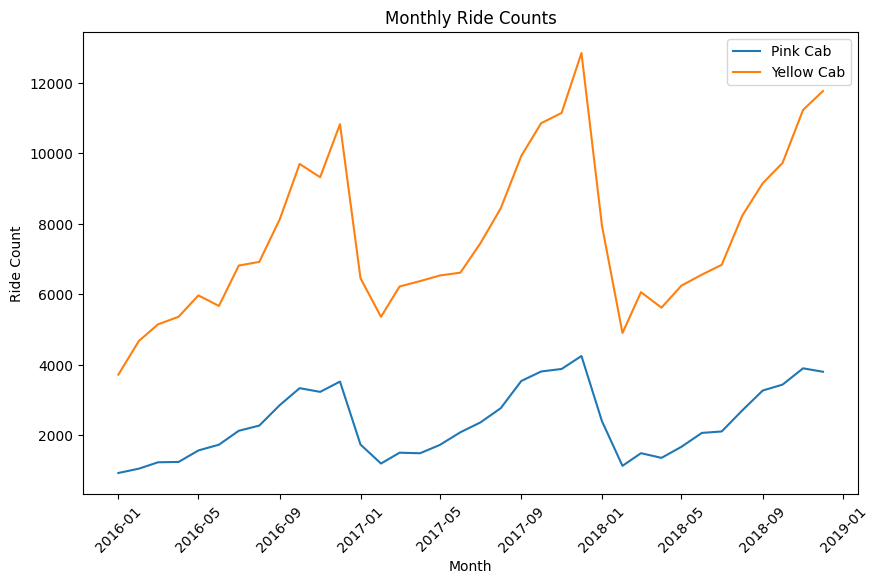

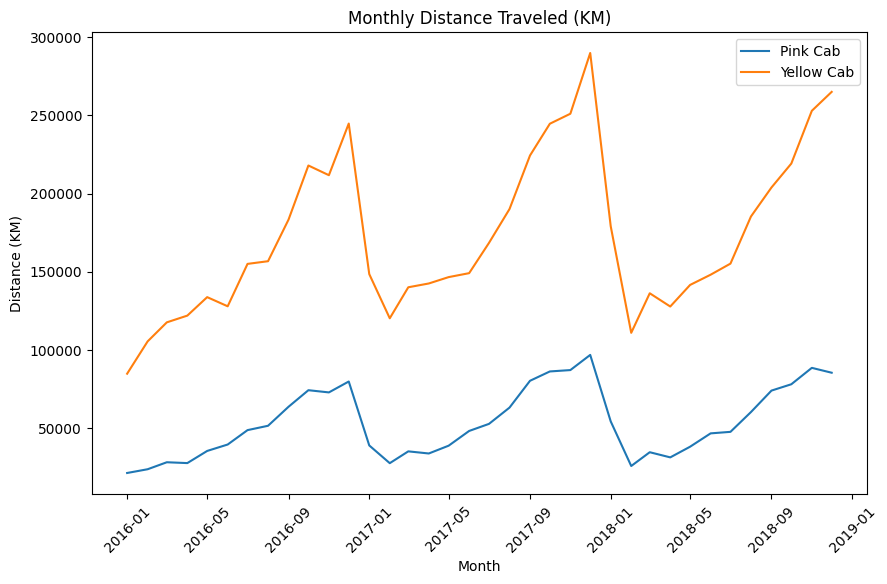

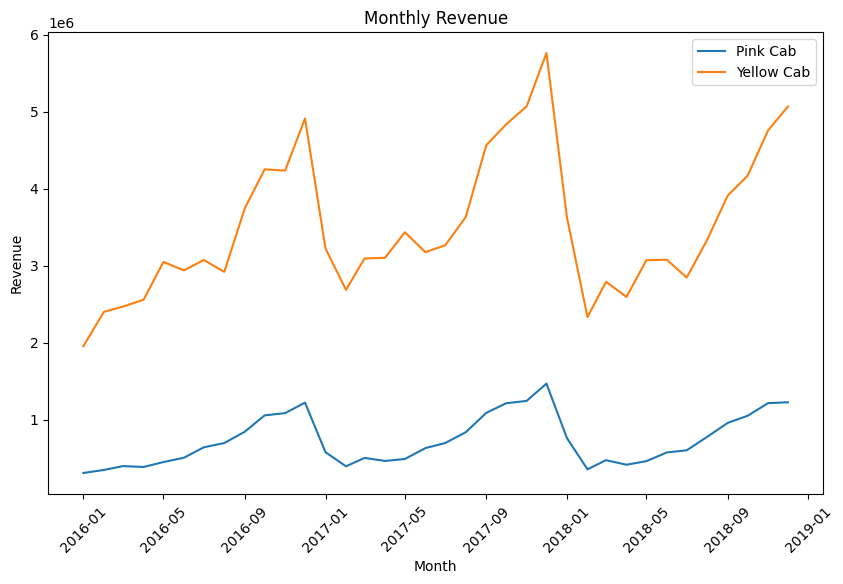

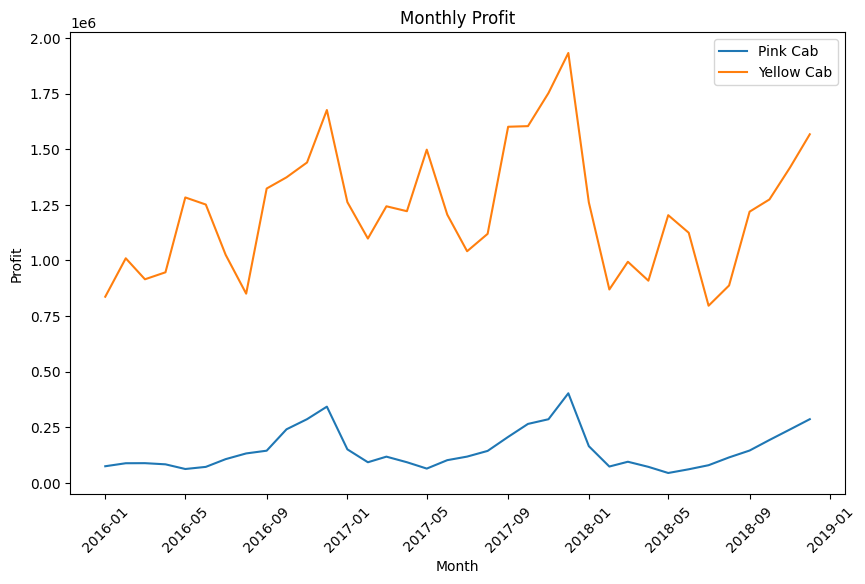

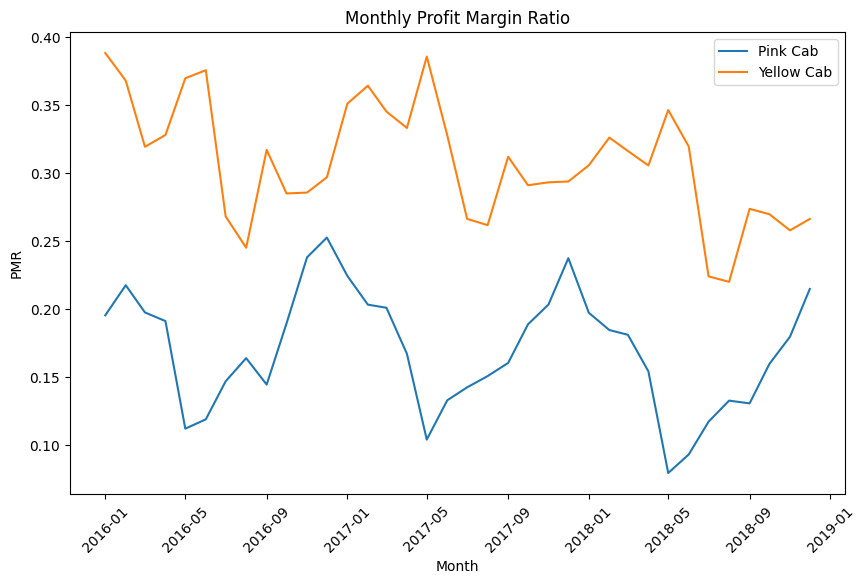

In [12]:
# Plot Seasonality

import matplotlib.pyplot as plt

# Reset the index for each DataFrame to make 'Chronological Month' accessible as a column
monthly_ride_count = monthly_ride_count.reset_index()
monthly_distance = monthly_distance.reset_index()
monthly_revenue = monthly_revenue.reset_index()
monthly_profit = monthly_profit.reset_index()
monthly_PMR = monthly_PMR.reset_index()

# Now, you can plot using these DataFrames directly

# Plot Monthly Ride Counts
plt.figure(figsize=(10, 6))
plt.plot(monthly_ride_count['Chronological Month'], monthly_ride_count['Pink Cab'], label='Pink Cab')
plt.plot(monthly_ride_count['Chronological Month'], monthly_ride_count['Yellow Cab'], label='Yellow Cab')
plt.title('Monthly Ride Counts')
plt.xlabel('Month')
plt.ylabel('Ride Count')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot Monthly Distance Traveled
plt.figure(figsize=(10, 6))
plt.plot(monthly_distance['Chronological Month'], monthly_distance['Pink Cab'], label='Pink Cab')
plt.plot(monthly_distance['Chronological Month'], monthly_distance['Yellow Cab'], label='Yellow Cab')
plt.title('Monthly Distance Traveled (KM)')
plt.xlabel('Month')
plt.ylabel('Distance (KM)')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot Monthly Revenue
plt.figure(figsize=(10, 6))
plt.plot(monthly_revenue['Chronological Month'], monthly_revenue['Pink Cab'], label='Pink Cab')
plt.plot(monthly_revenue['Chronological Month'], monthly_revenue['Yellow Cab'], label='Yellow Cab')
plt.title('Monthly Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot Monthly Profit
plt.figure(figsize=(10, 6))
plt.plot(monthly_profit['Chronological Month'], monthly_profit['Pink Cab'], label='Pink Cab')
plt.plot(monthly_profit['Chronological Month'], monthly_profit['Yellow Cab'], label='Yellow Cab')
plt.title('Monthly Profit')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot Monthly PMR
plt.figure(figsize=(10, 6))
plt.plot(monthly_PMR['Chronological Month'], monthly_PMR['Pink Cab'], label='Pink Cab')
plt.plot(monthly_PMR['Chronological Month'], monthly_PMR['Yellow Cab'], label='Yellow Cab')
plt.title('Monthly Profit Margin Ratio')
plt.xlabel('Month')
plt.ylabel('PMR')
plt.xticks(rotation=45)
plt.legend()
plt.show()


# Seasonality result

Hypothese: Are there predictable patterns in seasonality? For example, holidays or climate seasons.

Results:
- Yellow Cab has consistently higher ride counts, distance traveled, revenue and profit across all months.
- There are seasonal peaks in late-year months, from October to December, for both companies, suggesting higher demand during the holiday season.
- Yellow Cab's monthly Profit Margin Ratio has been slowly decreasing, but is still superior to Pink Cab's

# 2. Profit Margin Ratio analysis

Calculate overall average Profit Margin Ratio (PMR) for each company
Calculate PMR per city for each company
Calculate montlhy PMR for each company
Calculate Yellow Cab's PMR for 2017 and 2018 to determine the reduction.  

overall_profit_margin, city_profit_margin.head()


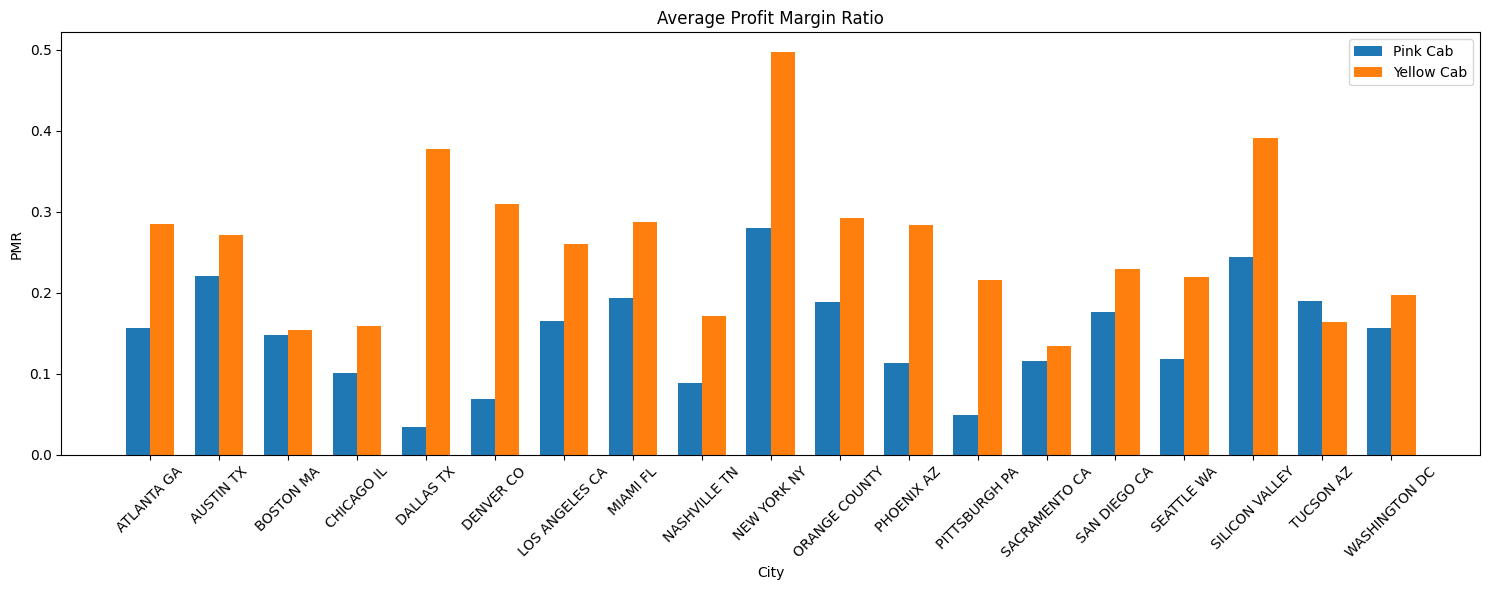

(Company
 Pink Cab      0.173808
 Yellow Cab    0.301345
 Name: Profit Margin Ratio, dtype: float64,
 np.float64(-0.10248144213557402))

In [16]:
# Calculate the overall average Profit Margin Ratio for each company
overall_profit_margin = master_data.groupby('Company')['Profit Margin Ratio'].mean()

# Calculate the average Profit Margin Ratio by city for each company
city_profit_margin = master_data.groupby(['City', 'Company'])['Profit Margin Ratio'].mean().unstack()

city_profit_margin = city_profit_margin.reset_index()

city_profit_margin.to_csv(os.path.join('DataSets', 'city_PMR.csv'), index=True)

# Plot PMR per city
plt.figure(figsize=(15, 6))
bar_width = 0.35
x = range(len(city_profit_margin['City']))

plt.bar(x, city_profit_margin['Pink Cab'], width=bar_width, label='Pink Cab')
plt.bar([i + bar_width for i in x], city_profit_margin['Yellow Cab'], width=bar_width, label='Yellow Cab')

plt.title('Average Profit Margin Ratio')
plt.xlabel('City')
plt.ylabel('PMR')
plt.xticks([i + bar_width / 2 for i in x], city_profit_margin['City'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Filter data for Yellow Cab in years 2018 and 2019 and calculate the average Profit Margin Ratio for each year
yellow_cab_2017 = master_data[(master_data['Company'] == 'Yellow Cab') & (master_data['Year'] == 2017)]
yellow_cab_2018 = master_data[(master_data['Company'] == 'Yellow Cab') & (master_data['Year'] == 2018)]

# Calculate the average Profit Margin Ratio for Yellow Cab in 2018 and 2019
average_pmr_yellow_cab_2017 = yellow_cab_2017['Profit Margin Ratio'].mean()
average_pmr_yellow_cab_2018 = yellow_cab_2018['Profit Margin Ratio'].mean()

# Calculate yellow cab's PMR variation percentual from 2017 to 2018
pmr_percentual_variation_2017_2018 = (average_pmr_yellow_cab_2018 - average_pmr_yellow_cab_2017) / average_pmr_yellow_cab_2017

# Display the overall and city-wise profit margin results
overall_profit_margin, pmr_percentual_variation_2017_2018

# Profit Margin Ratio Result

Hypothese: Which company has better Profit Margin Ratio? Does this change if aggregated by city or season?

 - Yellow Cab has consistent better Profit Margin Ratio across all cities except Tucson. It is on average 73% superior to Pink Cab.
 - Yellow Cab's monthly Profit Margin Ratio decreased 10% from 2017 to 2018.

# 3. Income Bracket Differences 

- Compare the number of users per income bracket between the two companies
- Compare the average customer life time value per city between the two companies
- Create a new column sepparating users in frequency of use brackets and compare the two comapnies

In [ ]:

# Calculate unique user counts per income bracket and company
income_bracket_user_distribution = (
    master_data.groupby(['Income Bracket', 'Company'],observed=True)['Customer ID']
    .nunique()
    .unstack()
    .fillna(0)
)

# Convert the counts to percentages for each company for easier comparison
income_bracket_user_percentage = (
    income_bracket_user_distribution.div(income_bracket_user_distribution.sum(axis=0), axis=1) * 100
)

# Calculate total revenue per customer as a proxy for CLTV
customer_revenue = master_data.groupby(['Customer ID', 'Company', 'City'])['Price Charged'].sum().reset_index()
customer_revenue.columns = ['Customer ID', 'Company', 'City', 'Customer Lifetime Value']

# Calculate the average CLTV per city for each company
average_cltv_city = customer_revenue.groupby(['City', 'Company'])['Customer Lifetime Value'].mean().unstack()

# Recalculate the distribution of users by frequency of use brackets for each company
frequency_distribution = master_data.groupby(['Use Frequency Bracket', 'Company'],observed=True)['Customer ID'].nunique().unstack().fillna(0)


# Count the number of unique customers per company in the master_data
customer_counts_per_company = master_data.groupby('Company')['Customer ID'].nunique()

# Calculate the percentage difference in customer count between the two companies
percentual_difference_customer_count = (customer_counts_per_company['Yellow Cab'] - customer_counts_per_company['Pink Cab']) / customer_counts_per_company['Pink Cab'] * 100

# Counting unique customers per frequency bracket per company
frequency_bracket_counts = master_data.groupby(['Use Frequency Bracket', 'Company'], observed=True)['Customer ID'].nunique().unstack().fillna(0)

# Summing the user counts for the "5 to 14 rides" and "15 rides or more" brackets for each company
high_usage_brackets_sum = frequency_bracket_counts.loc[['5 to 14 rides', '15 rides or more']].sum()

# Calculating the percentual difference between the two companies based on the summed high usage brackets
frequency_bracket_percentual_difference = ((high_usage_brackets_sum['Yellow Cab'] - high_usage_brackets_sum['Pink Cab']) /
                                           high_usage_brackets_sum['Pink Cab']) * 100



# Plotting the raw count of unique users in each income bracket for each company
income_bracket_user_distribution.plot(kind='bar', figsize=(10, 6))
plt.title("Distribution of Unique Users by Income Bracket and Company")
plt.ylabel("Number of Unique Users")
plt.xlabel("Income Bracket")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the percentage distribution of users across income brackets for each company
income_bracket_user_percentage.plot(kind='bar', figsize=(10, 6))
plt.title("Percentage Distribution of Unique Users by Income Bracket and Company")
plt.ylabel("Percentage of Unique Users")
plt.xlabel("Income Bracket")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the corrected frequency of use bracket distribution for each company
frequency_distribution.plot(kind='bar', figsize=(10, 6))
plt.title("Corrected Distribution of Users by Frequency of Use Bracket and Company")
plt.ylabel("Number of Unique Users")
plt.xlabel("Use Frequency Bracket")
plt.legend(title="Company")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

customer_counts_per_company, percentual_difference_customer_count
frequency_bracket_counts, frequency_bracket_percentual_difference

# Income Bracket Results

- The percentage distribution of customers by income bracket is equivalent between the two companies.
- Yellow Cab has 23% more customers.
- Yellow cab has almost triple as much recurring customers (186% more cusrtomers with 5 or more rides)

# 4. Profit per distance traveled

- Which days of the week have more usage?



In [9]:
# Separate data by company
pink_cab_data = master_data[master_data['Company'] == 'Pink Cab']
yellow_cab_data = master_data[master_data['Company'] == 'Yellow Cab']

# Calculate correlation between 'KM Travelled' and 'Profit Margin Ratio' for each company
pink_cab_corr = pink_cab_data['KM Travelled'].corr(pink_cab_data['Profit Margin Ratio'])
yellow_cab_corr = yellow_cab_data['KM Travelled'].corr(yellow_cab_data['Profit Margin Ratio'])

# Create scatter plots for visual inspection of correlation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pink Cab
ax1.scatter(pink_cab_data['KM Travelled'], pink_cab_data['Profit Margin Ratio'], alpha=0.5)
ax1.set_title(f'Pink Cab: Correlation = {pink_cab_corr:.2f}')
ax1.set_xlabel('KM Travelled')
ax1.set_ylabel('Profit Margin Ratio')

# Yellow Cab
ax2.scatter(yellow_cab_data['KM Travelled'], yellow_cab_data['Profit Margin Ratio'], alpha=0.5)
ax2.set_title(f'Yellow Cab: Correlation = {yellow_cab_corr:.2f}')
ax2.set_xlabel('KM Travelled')

plt.tight_layout()
plt.show()

pink_cab_corr, yellow_cab_corr


NameError: name 'plt' is not defined

# Result Profit per Distance

Hypothese: Is there a positive correlation between distance traveled and profit margin for either company?

- There is no direct correlation between distance traveled and profit margin.

# 5 City comparison

- Compare profit, cost, revenue and number of rides per city

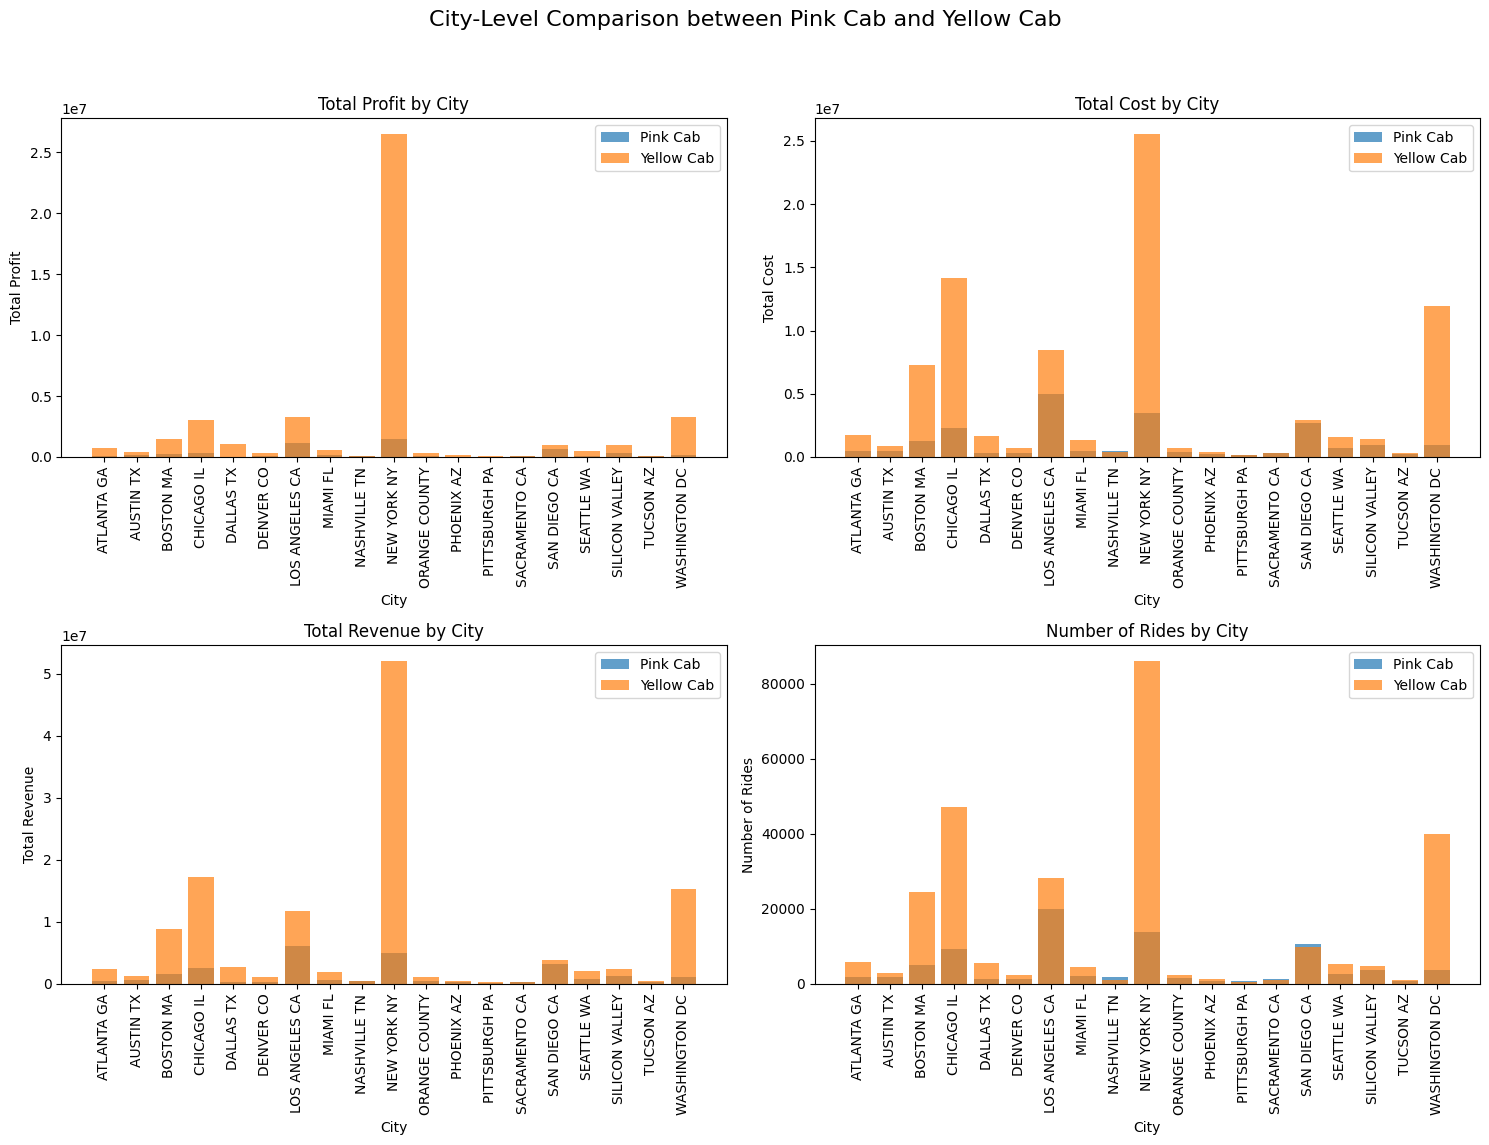

In [13]:
# Group data by 'Company' and 'City' and calculate total profit, total cost, total revenue, and number of rides per city
city_comparison_data = master_data.groupby(['Company', 'City']).agg(
    Total_Profit=('Profit per Trip', 'sum'),
    Total_Cost=('Cost of Trip', 'sum'),
    Total_Revenue=('Price Charged', 'sum'),
    Number_of_Rides=('Transaction ID', 'count')
).reset_index()

# Split data by company
pink_cab_city_data = city_comparison_data[city_comparison_data['Company'] == 'Pink Cab']
yellow_cab_city_data = city_comparison_data[city_comparison_data['Company'] == 'Yellow Cab']

# Merge to compare side by side
city_comparison = pd.merge(
    pink_cab_city_data[['City', 'Total_Profit', 'Total_Cost', 'Total_Revenue', 'Number_of_Rides']],
    yellow_cab_city_data[['City', 'Total_Profit', 'Total_Cost', 'Total_Revenue', 'Number_of_Rides']],
    on='City',
    suffixes=('_Pink', '_Yellow')
)

# Calculate differences between companies for each metric
city_comparison['Profit Difference'] = city_comparison['Total_Profit_Pink'] - city_comparison['Total_Profit_Yellow']
city_comparison['Cost Difference'] = city_comparison['Total_Cost_Pink'] - city_comparison['Total_Cost_Yellow']
city_comparison['Revenue Difference'] = city_comparison['Total_Revenue_Pink'] - city_comparison['Total_Revenue_Yellow']
city_comparison['Rides Difference'] = city_comparison['Number_of_Rides_Pink'] - city_comparison['Number_of_Rides_Yellow']

# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("City-Level Comparison between Pink Cab and Yellow Cab", fontsize=16)

# Plot Total Profit
axs[0, 0].bar(city_comparison['City'], city_comparison['Total_Profit_Pink'], label="Pink Cab", alpha=0.7)
axs[0, 0].bar(city_comparison['City'], city_comparison['Total_Profit_Yellow'], label="Yellow Cab", alpha=0.7)
axs[0, 0].set_title("Total Profit by City")
axs[0, 0].set_xlabel("City")
axs[0, 0].set_ylabel("Total Profit")
axs[0, 0].legend()
axs[0, 0].tick_params(axis='x', rotation=90)

# Plot Total Cost
axs[0, 1].bar(city_comparison['City'], city_comparison['Total_Cost_Pink'], label="Pink Cab", alpha=0.7)
axs[0, 1].bar(city_comparison['City'], city_comparison['Total_Cost_Yellow'], label="Yellow Cab", alpha=0.7)
axs[0, 1].set_title("Total Cost by City")
axs[0, 1].set_xlabel("City")
axs[0, 1].set_ylabel("Total Cost")
axs[0, 1].legend()
axs[0, 1].tick_params(axis='x', rotation=90)

# Plot Total Revenue
axs[1, 0].bar(city_comparison['City'], city_comparison['Total_Revenue_Pink'], label="Pink Cab", alpha=0.7)
axs[1, 0].bar(city_comparison['City'], city_comparison['Total_Revenue_Yellow'], label="Yellow Cab", alpha=0.7)
axs[1, 0].set_title("Total Revenue by City")
axs[1, 0].set_xlabel("City")
axs[1, 0].set_ylabel("Total Revenue")
axs[1, 0].legend()
axs[1, 0].tick_params(axis='x', rotation=90)

# Plot Number of Rides
axs[1, 1].bar(city_comparison['City'], city_comparison['Number_of_Rides_Pink'], label="Pink Cab", alpha=0.7)
axs[1, 1].bar(city_comparison['City'], city_comparison['Number_of_Rides_Yellow'], label="Yellow Cab", alpha=0.7)
axs[1, 1].set_title("Number of Rides by City")
axs[1, 1].set_xlabel("City")
axs[1, 1].set_ylabel("Number of Rides")
axs[1, 1].legend()
axs[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Results per city

Hypothese: Are there specific states or cities where one company outperforms the other significantly?

 - Yellow cab outperforms Pink cab in almost every city, most significantly in New York, Washington, Chicago, Boston, Dallas, and Atlanta.

# Conclusion

## Yellow Cab is the clear better investment

Favorable:
- Yellow Cab has consistently higher ride counts, distance traveled, revenue and profit across all months.
- Yellow Cab has 23% more customers.
- Yellow cab has almost triple as much recurring customers (186% more cusrtomers with 5 or more rides)
- Yellow cab outperforms Pink cab in almost every city, most significantly in New York, Washington, Chicago, Boston, Dallas, and Atlanta.

Neutral:
- There are seasonal peaks in late-year months, from October to December, for both companies, suggesting higher demand during the holiday season.
- There is no direct correlation between distance traveled and profit margin.
- The percentage distribution of customers by income bracket is equivalent between the two companies.

Unfavorable:
- Yellow Cab's monthly Profit Margin Ratio has been slowly decreasing, but is still superior to Pink Cab's

